In part 1, we are going to train a model to detect key facial points on humans. The dataset has been found on kaggle




In [1]:
from google.colab import drive
drive.mount('/content/drive')

## Path for the dataset can be found at 
## drive/'My Drive'/'Colab Notebooks'/'U-demy - AI Program'/'Emotion AI Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Changing directory to where the notebook and dataset is located
%cd /content/drive/'My Drive'/'Colab Notebooks'/'U-demy - AI Program'/

/content/drive/My Drive/Colab Notebooks/U-demy - AI Program


In [3]:
## Importing all necessary TensorFlow, Keras, and general purpose data science modules
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
## Loading up the facial key points data into pandas
facial_key_points_df = pd.read_csv('Emotion AI Dataset/data.csv')

In [5]:
facial_key_points_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,24.972418,36.348203,56.402841,31.171586,80.709708,30.595738,38.187845,30.595738,17.275454,29.534964,45.805390,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,15.979592,38.076531,56.941270,29.605102,81.314059,30.754762,35.059410,29.566780,8.578912,32.096032,53.649433,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,21.621652,39.095524,62.388142,32.089787,85.829396,38.724104,42.595762,30.541779,11.230184,34.485512,53.318891,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,16.850204,44.409861,51.463469,27.161327,77.354898,19.562755,34.135510,32.830102,9.731633,41.152347,54.075935,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [6]:
## Obtaining information about the dataset
facial_key_points_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [7]:
## Checking for missing values within the dataset
facial_key_points_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [8]:
## Ther are 2140 data points and 31 features present in th dataset
facial_key_points_df.shape

(2140, 31)

In [9]:
## The pixels in Image are in 1D format. The actual image is of shape 96,96, so we are going to reshape the 1D array into a 2D array
facial_key_points_df['Image'] = facial_key_points_df['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96,96))

In [10]:
facial_key_points_df['Image'][0].shape ## reshape was successful

(96, 96)

In [11]:
facial_key_points_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,22.361617,38.034571,56.147991,29.222304,79.617523,29.656570,39.272084,29.413747,15.761707,30.452947,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,2.768804,2.654903,2.819914,2.867131,3.312647,3.627187,2.609648,2.842219,3.337901,3.644342,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,11.054589,26.521633,35.581733,15.859361,55.549929,10.522325,25.060327,16.476000,3.826243,13.224453,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,20.631964,36.569765,54.562757,27.590944,77.732395,27.658656,37.555192,27.798773,13.540535,28.268263,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,22.529600,37.876900,56.239984,29.468466,79.797607,29.753523,39.247681,29.528098,15.760876,30.333323,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,24.202338,39.401034,57.926361,31.079433,81.559651,31.763791,40.824154,31.134740,17.871569,32.661300,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,40.050971,50.002113,67.752000,40.293408,94.269957,48.823425,51.300571,39.445859,39.676082,44.857962,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


Will now be doing some visualization on the dataset

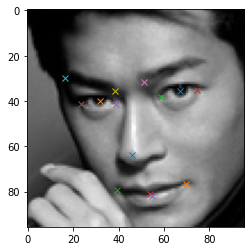

In [12]:
## Plotting the image
i = np.random.randint(0, len(facial_key_points_df['Image']))
plt.imshow(facial_key_points_df['Image'][i], cmap='gray')

## Plotting keypoints on image
## There are 31 features in the dataset and for each object there are two columns
## x and y. That is why the step is set to 2. at each iteration we take the previous column (x [j-1])
## and the current column (y [j])
for j in range(1, 31, 2):
  plt.plot(facial_key_points_df.loc[i][j-1], facial_key_points_df.loc[i][j], 'x')

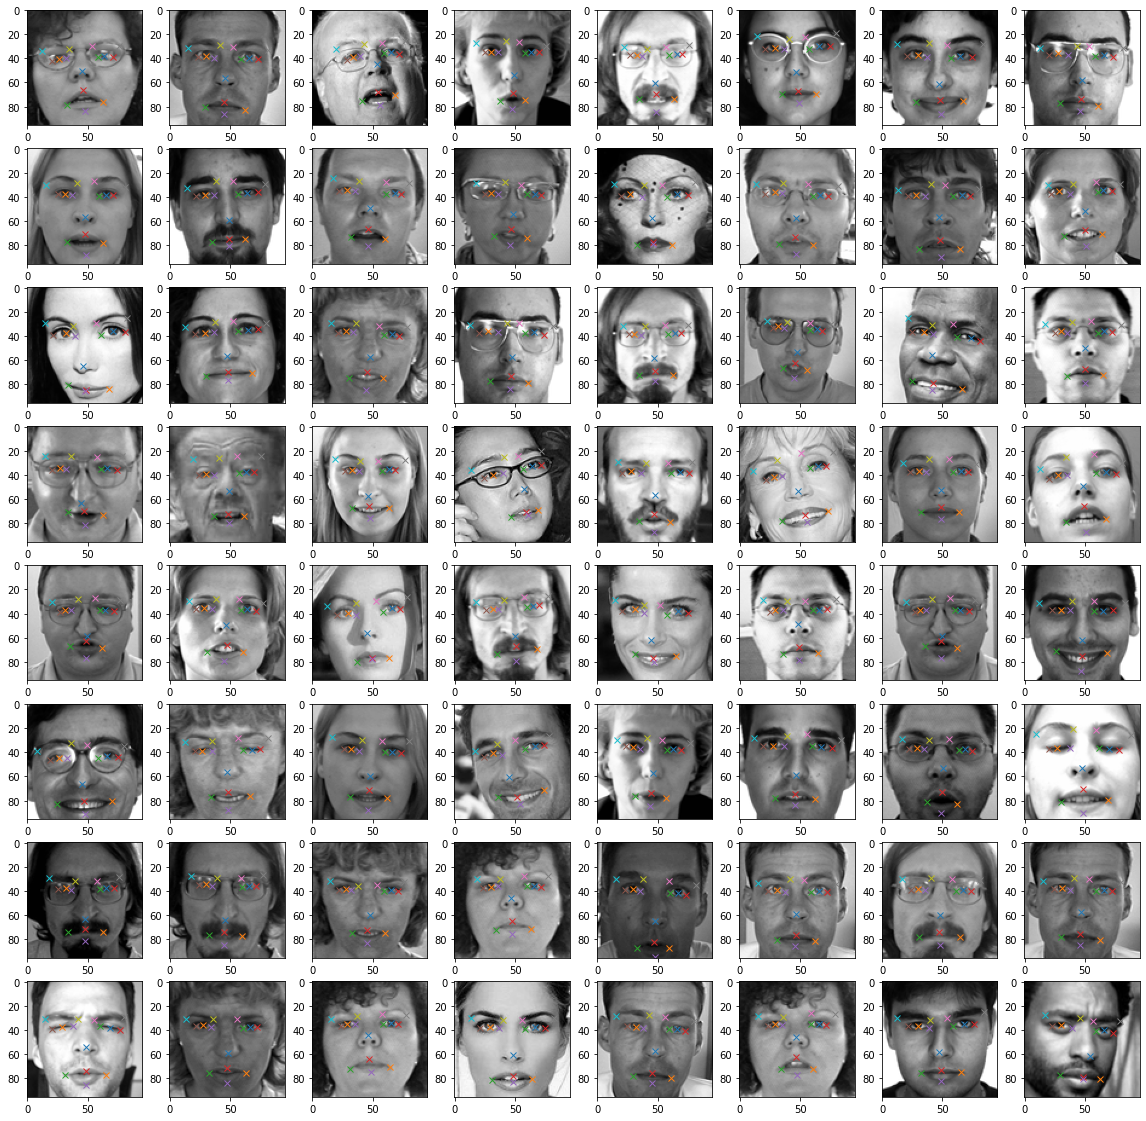

In [13]:
fig = plt.figure(figsize=(20,20))

for i in range(64):
  image_index = np.random.randint(1, len(facial_key_points_df['Image']))
  ax = fig.add_subplot(8,8,i+1)
  image = plt.imshow(facial_key_points_df['Image'][image_index], cmap='gray')
  for j in range(1, 31, 2):
    plt.plot(facial_key_points_df.loc[image_index][j-1], facial_key_points_df.loc[image_index][j], 'x')

The key points dataset is quite small. In order for the model to learn and make accurate predictions we need to apply some image augmentation to increase the dataset and introduce new "viewports". This should increase the model accuracy by making it more robust

In [16]:
facial_key_points_df_copy = facial_key_points_df.copy()

In [18]:
column_name = facial_key_points_df_copy.columns[:-1]
column_name

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [19]:
## First augmentation technique being applied will be a horizontal flip
facial_key_points_df_copy['Image'] = facial_key_points_df_copy['Image'].apply(lambda x: np.flip(x, axis=1))

## Will need to subtract the value of the x column by the height of the image to get new coordiante location
for i in range(len(column_name)):
  if i % 2 == 0: ## x coordintes
    facial_key_points_df_copy[column_name[i]] = facial_key_points_df_copy[column_name[i]].apply(lambda x: 96. - float(x))

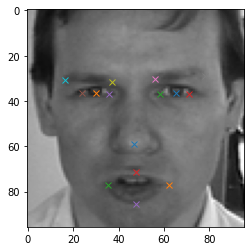

In [20]:
## Again, visualizing the normal image and comparing it to the flipped
image_id = 150
plt.imshow(facial_key_points_df['Image'][image_id], cmap='gray')
for j in range(1, 31, 2):
    plt.plot(facial_key_points_df.loc[image_id][j-1], facial_key_points_df.loc[image_id][j], 'x')


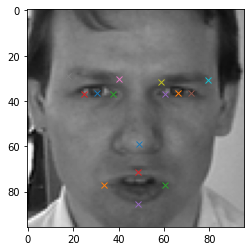

In [23]:
plt.imshow(facial_key_points_df_copy['Image'][image_id], cmap='gray')
for j in range(1,31,2):
  plt.plot(facial_key_points_df_copy.loc[image_id][j-1], facial_key_points_df_copy.loc[image_id][j], 'x')

In [24]:
## Will be combining the augmented dataframe and the orginal dataframe
augmented_df = np.concatenate((facial_key_points_df, facial_key_points_df_copy))

In [25]:
augmented_df.shape ## The number of datapoints doubled, effectively giving us double the images to train on 

(4280, 31)

In [26]:
## Will be applying vertical flip to the images
facial_key_points_df_copy = facial_key_points_df.copy()

In [27]:
## Will be applying vertical flip to the Images
facial_key_points_df_copy['Image'] = facial_key_points_df_copy['Image'].apply(lambda x: np.flip(x, axis=0))

## Will be applying the flip as well to the y-axis
for col in range(len(column_name)):
  if i % 2 == 1: ## y coordinates
    facial_key_points_df_copy[column_name[col]] = facial_key_points_df_copy[column_name[col]].apply(lambda x: 96. - float(x))

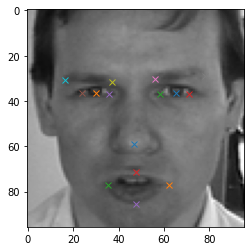

In [28]:
## Again, visualizing the normal image and comparing it to the flipped
image_id = 150
plt.imshow(facial_key_points_df['Image'][image_id], cmap='gray')
for j in range(1, 31, 2):
    plt.plot(facial_key_points_df.loc[image_id][j-1], facial_key_points_df.loc[image_id][j], 'x')

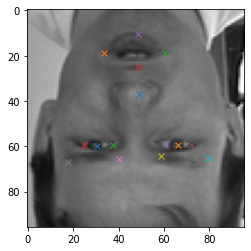

In [29]:
plt.imshow(facial_key_points_df_copy['Image'][image_id], cmap='gray')
for j in range(1,31,2):
  plt.plot(facial_key_points_df_copy.loc[image_id][j-1], facial_key_points_df_copy.loc[image_id][j], 'x')

In [31]:
## Combining the datasets
augmented_df = np.concatenate((augmented_df, facial_key_points_df_copy))

In [32]:
augmented_df.shape

(6420, 31)

In [39]:
facial_key_points_df_copy = facial_key_points_df.copy()

In [40]:
## Will be applying a brightness filter to the images
import random
facial_key_points_df_copy['Image'] = facial_key_points_df_copy['Image'].apply(lambda x: np.clip(random.uniform(1.5,2) * x, 0, 255))

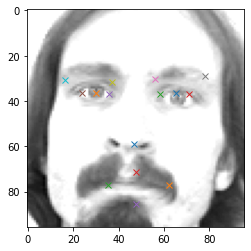

In [41]:
## Visualize the images with different brightness
plt.imshow(facial_key_points_df_copy['Image'][0], cmap='gray')
for j in range(1,31,2):
  plt.plot(facial_key_points_df_copy.loc[image_id][j-1], facial_key_points_df_copy.loc[image_id][j], 'x')

In [42]:
## Appending data
augmented_df = np.concatenate((augmented_df, facial_key_points_df_copy))

In [43]:
augmented_df.shape

(8560, 31)